##### The cell below is for you to keep track of the libraries used and install those libraries quickly
##### Ensure that the proper library names are used and the syntax of `%pip install PACKAGE_NAME` is followed

In [ ]:
# %pip install pandas
# %pip install pyarrow
# %pip install numpy
# %pip install scikit-learn
# %pip install imbalanced-learn
# %pip install matplotlib
# add commented pip installation lines for packages used as shown above for ease of testing
# the line should be of the format %pip install PACKAGE_NAME 

In [1]:
# Can have as many cells as you want for code
import pandas as pd

filepath = "./data/catB_train_final_clean.parquet" 
df = pd.read_parquet(filepath, engine='pyarrow')

In [ ]:
df.head()

In [ ]:
df["f_purchase_lh"].dtype
#df.iloc[:,200]

In [ ]:
df.iloc[:,1].value_counts()

# (SKIP) Data Processing

In [ ]:
## Clean Data
df['f_purchase_lh'].fillna(0, inplace=True)

# Identifiy numeric columns and fill null values with the median value
numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns
df[numeric_cols] = df[numeric_cols].apply(lambda x: x.fillna(x.median()))

# Drop non-numeric cols
non_numeric_cols = df.select_dtypes(include=["string", "object"]).columns
df = df.drop(columns=non_numeric_cols)  

y = df["f_purchase_lh"]
X = df.drop(columns=['f_purchase_lh'])

In [ ]:
# Scale Numeric Features
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler().fit(df[numeric_cols])
df[numeric_cols] = scaler.transform(df[numeric_cols])

# Encode Categorical Data
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False, handle_unknown='ignore').fit(raw_df[categorical_cols])



# Decide between SMOTE, oversampling or undersampling

In [2]:
from sklearn.model_selection import train_test_split

y = df["f_purchase_lh"]
X = df.drop(columns=['clntnum','f_purchase_lh'])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

In [3]:
from collections import Counter
print('Before:', Counter(y_train))

'''
## SMOTENC for categorical features
from imblearn.over_sampling import SMOTENC

smotenc = SMOTENC(categorical_features= 'auto', random_state=42)
X_train, y_train = smotenc.fit_resample(X_train, y_train)
# train accuracy:  1.0, val accuracy:  0.9550428867199053
# but the TPR is really low: got 11/140 so change
'''
'''
## Oversampling
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)

X_train, y_train = ros.fit_resample(X_train, y_train)
# slightly worse than smote
'''


## Undersampling
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
X_train, y_train = rus.fit_resample(X_train, y_train)

# After testing out undersampling, initial train accuracy:  1.0 and val accuracy:  0.7352854185152322. 
# May be due to loss of information from the majority class


print('After:', Counter(y_train))

Before: Counter({'0': 12967, '1': 557})
After: Counter({'0': 557, '1': 557})


# Random Forest

In [4]:
from sklearn.ensemble import RandomForestClassifier

In [5]:
base_rf = RandomForestClassifier(n_jobs=-1, random_state=42).fit(X_train, y_train)
print("train accuracy: ", base_rf.score(X_train, y_train))
print("val accuracy: ", base_rf.score(X_val, y_val))

train accuracy:  1.0
val accuracy:  0.7352854185152322


              precision    recall  f1-score   support

           0       0.98      0.74      0.84      3241
           1       0.10      0.65      0.17       140

    accuracy                           0.74      3381
   macro avg       0.54      0.69      0.51      3381
weighted avg       0.94      0.74      0.81      3381



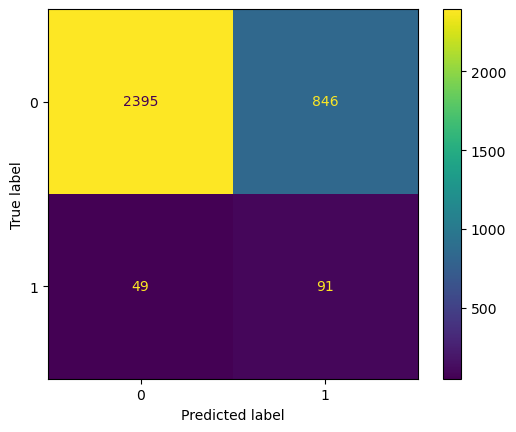

In [22]:
eval(base_rf)

## Hyper Parameters

In [19]:
# Hyper Parameters
import matplotlib.pyplot as plt

# n_estimators = number of decision trees
# max_depth and max_leaf nodes: edit to reduce overfitting
def test_params(**params):
    model = RandomForestClassifier(random_state=42, n_jobs=-1, **params).fit(X_train, y_train)
    return model.score(X_train, y_train), model.score(X_val, y_val)
def param_model(**params):
    model = RandomForestClassifier(random_state=42, n_jobs=-1, **params).fit(X_train, y_train)
    return model

### n_estimators = 80

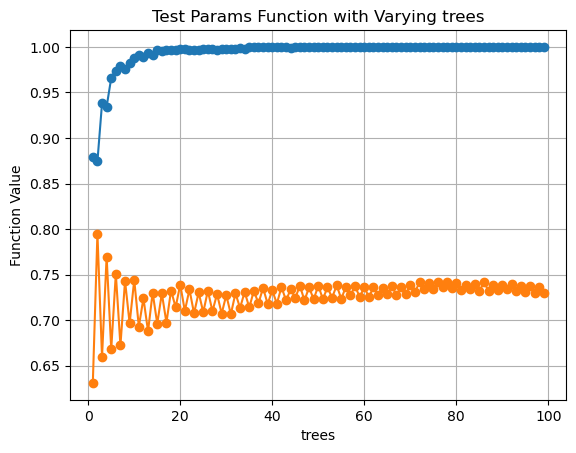

In [7]:
# Test n_estimators
max_depth_values = range(1, 100)
y_values = [test_params(n_estimators = i) for i in max_depth_values]
plt.plot(max_depth_values, y_values, marker='o')
plt.title('Test Params Function with Varying trees')
plt.xlabel('trees')
plt.ylabel('Function Value')
plt.grid(True)
plt.show()

              precision    recall  f1-score   support

           0       0.97      0.81      0.88      3241
           1       0.09      0.43      0.15       140

    accuracy                           0.80      3381
   macro avg       0.53      0.62      0.52      3381
weighted avg       0.93      0.80      0.85      3381



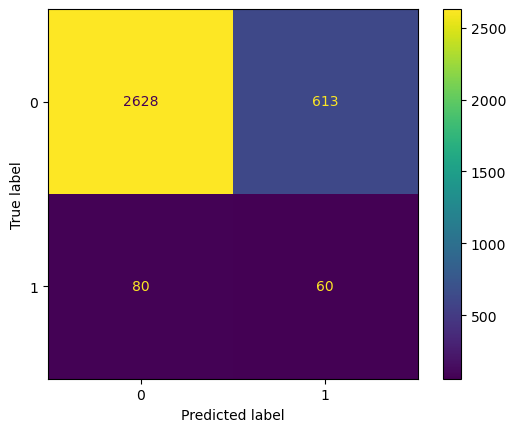

In [32]:
test_params(n_estimators = 2)
eval(param_model(n_estimators = 2)) # Fake

              precision    recall  f1-score   support

           0       0.98      0.75      0.85      3241
           1       0.10      0.65      0.17       140

    accuracy                           0.74      3381
   macro avg       0.54      0.70      0.51      3381
weighted avg       0.94      0.74      0.82      3381



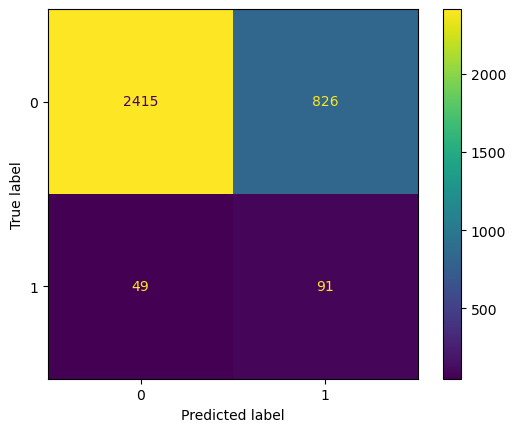

In [41]:
eval(param_model(n_estimators = 80))

### max_depth = 30

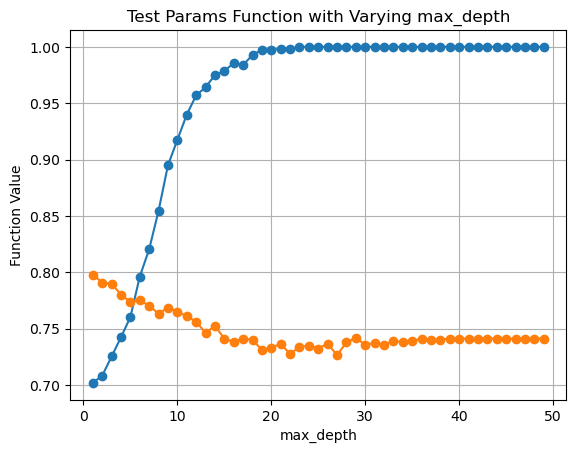

In [42]:
# Test max_depth
max_depth_values = range(1, 50)
y_values = [test_params(n_estimators = 80, max_depth = i) for i in max_depth_values]
plt.plot(max_depth_values, y_values, marker='o')
plt.title('Test Params Function with Varying max_depth')
plt.xlabel('max_depth')
plt.ylabel('Function Value')
plt.grid(True)
plt.show()

              precision    recall  f1-score   support

           0       0.98      0.74      0.85      3241
           1       0.10      0.66      0.17       140

    accuracy                           0.74      3381
   macro avg       0.54      0.70      0.51      3381
weighted avg       0.94      0.74      0.82      3381



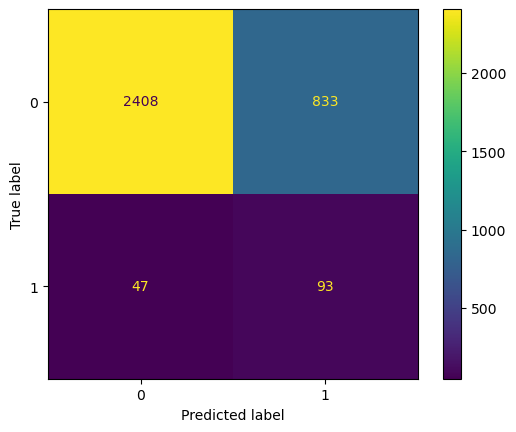

In [69]:
eval(param_model(n_estimators = 80, max_depth = 37))

### checking max_leaf and min_samples_leaf

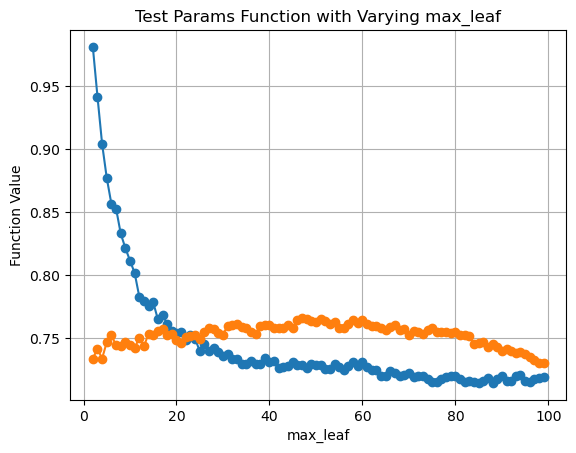

In [82]:
# Test max_leaf
max_leaf_values = range(2, 100)
y_values = [test_params(n_estimators = 80, max_depth = 37, min_samples_leaf = i) for i in max_leaf_values]
plt.plot(max_leaf_values, y_values, marker='o')
plt.title('Test Params Function with Varying max_leaf')
plt.xlabel('max_leaf')
plt.ylabel('Function Value')
plt.grid(True)
plt.show()

              precision    recall  f1-score   support

           0       0.98      0.75      0.85      3241
           1       0.09      0.59      0.16       140

    accuracy                           0.75      3381
   macro avg       0.54      0.67      0.51      3381
weighted avg       0.94      0.75      0.82      3381



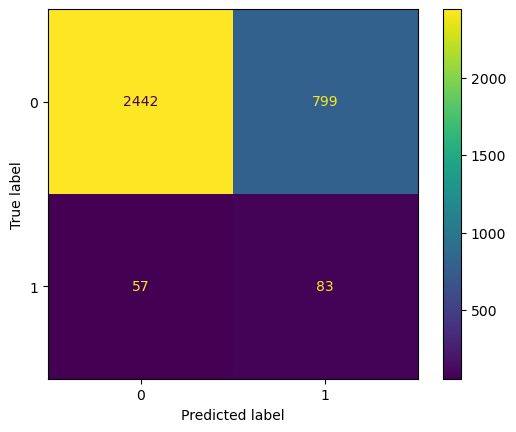

In [89]:
eval(param_model(n_estimators = 80, 
                 max_depth = 37, 
                 min_samples_leaf = 5))

### Max_features: 
research says sqrt or log2 is good

              precision    recall  f1-score   support

           0       0.98      0.74      0.84      3241
           1       0.10      0.68      0.18       140

    accuracy                           0.74      3381
   macro avg       0.54      0.71      0.51      3381
weighted avg       0.95      0.74      0.82      3381



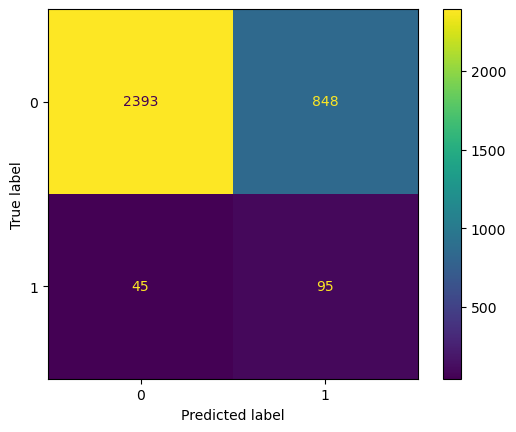

In [102]:
# Max_features -- Choices: sqrt, log2, some number
eval(param_model(n_estimators = 80, 
                 max_depth = 37, 
                 max_features = 3))

              precision    recall  f1-score   support

           0       0.98      0.74      0.85      3241
           1       0.10      0.66      0.17       140

    accuracy                           0.74      3381
   macro avg       0.54      0.70      0.51      3381
weighted avg       0.94      0.74      0.82      3381



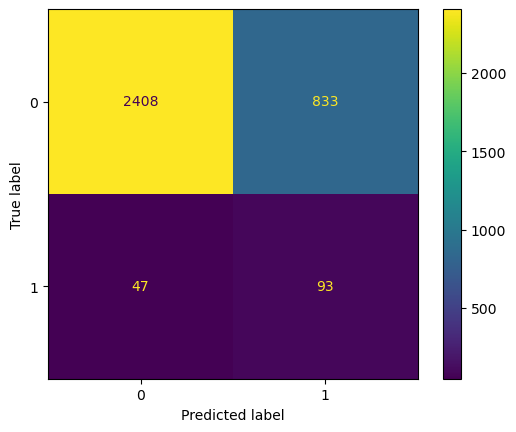

In [94]:
eval(param_model(n_estimators = 80, 
            max_depth = 37, 
            max_features = 'sqrt')) #default

              precision    recall  f1-score   support

           0       0.98      0.75      0.85      3241
           1       0.10      0.63      0.17       140

    accuracy                           0.74      3381
   macro avg       0.54      0.69      0.51      3381
weighted avg       0.94      0.74      0.82      3381



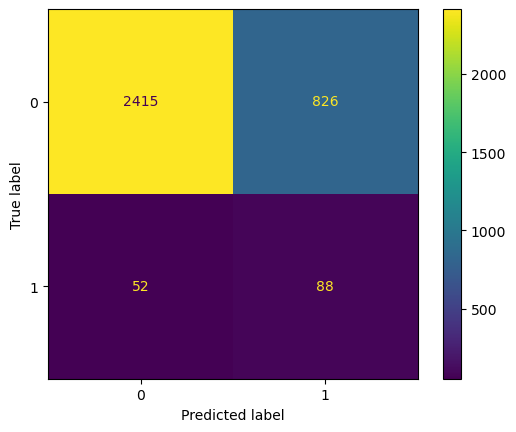

In [91]:
eval(param_model(n_estimators = 80, 
                 max_depth = 37, 
                 max_features = 'log2'))

### min_samples_split and min_samples_leaf == split nodes that has 2 or more

In [123]:
max_leaf_values = range(0, 1, 0.01)
y_values = [test_params(n_estimators = 80, 
                        max_depth = 37, 
                        max_features = 3,
                        min_impurity_decrease = i) for i in max_leaf_values]
plt.plot(max_leaf_values, y_values, marker='o')
plt.title('Test Params Function with Varying max_leaf')
plt.xlabel('max_leaf')
plt.ylabel('Function Value')
plt.grid(True)
plt.show()

TypeError: 'float' object cannot be interpreted as an integer

              precision    recall  f1-score   support

           0       0.98      0.73      0.84      3241
           1       0.10      0.69      0.17       140

    accuracy                           0.73      3381
   macro avg       0.54      0.71      0.51      3381
weighted avg       0.95      0.73      0.81      3381



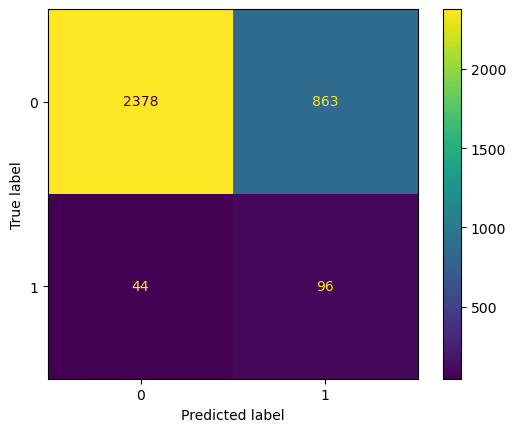

In [130]:
# min_impurity_decrease == threshold for splitting node, uses gini value, default is 0, increase to reduce overfitting
# e.g. 1e-6 or -7

eval(param_model(n_estimators = 80, 
                 max_depth = 37, 
                 max_features = 3,
                 min_impurity_decrease = 1e-7
                 ))

              precision    recall  f1-score   support

           0       0.98      0.74      0.84      3241
           1       0.10      0.69      0.18       140

    accuracy                           0.74      3381
   macro avg       0.54      0.71      0.51      3381
weighted avg       0.95      0.74      0.82      3381



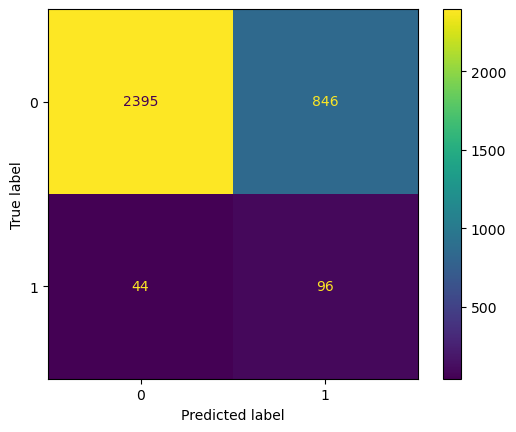

In [128]:
eval(param_model(n_estimators = 80, 
                 max_depth = 37, 
                 max_features = 3,
                 min_impurity_decrease = 1e-10
                 ))

### bootstrap = False

              precision    recall  f1-score   support

           0       0.98      0.74      0.84      3241
           1       0.10      0.69      0.18       140

    accuracy                           0.74      3381
   macro avg       0.54      0.71      0.51      3381
weighted avg       0.95      0.74      0.82      3381



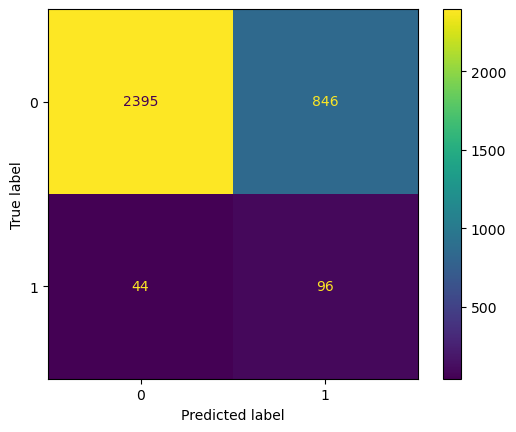

In [132]:
# bootstrap, max_samples (random picking with replacement)
eval(param_model(n_estimators = 80, 
                 max_depth = 37, 
                 max_features = 3,
                 min_impurity_decrease = 1e-10,
                 bootstrap = True
                 ))

              precision    recall  f1-score   support

           0       0.98      0.72      0.83      3241
           1       0.09      0.69      0.17       140

    accuracy                           0.72      3381
   macro avg       0.54      0.70      0.50      3381
weighted avg       0.94      0.72      0.80      3381



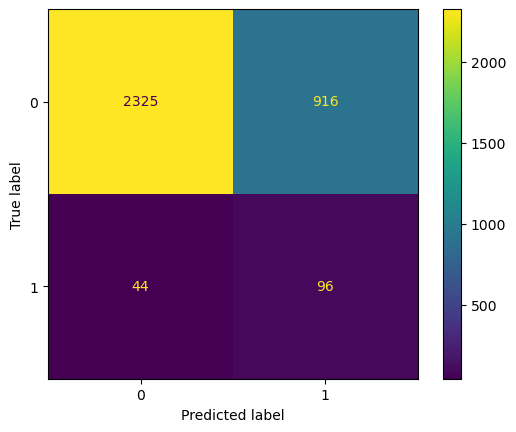

In [135]:
eval(param_model(n_estimators = 80, 
                 max_depth = 37, 
                 max_features = 3,
                 min_impurity_decrease = 1e-10,
                 bootstrap=False))

              precision    recall  f1-score   support

           0       0.98      0.73      0.84      3241
           1       0.10      0.66      0.17       140

    accuracy                           0.72      3381
   macro avg       0.54      0.70      0.50      3381
weighted avg       0.94      0.72      0.81      3381



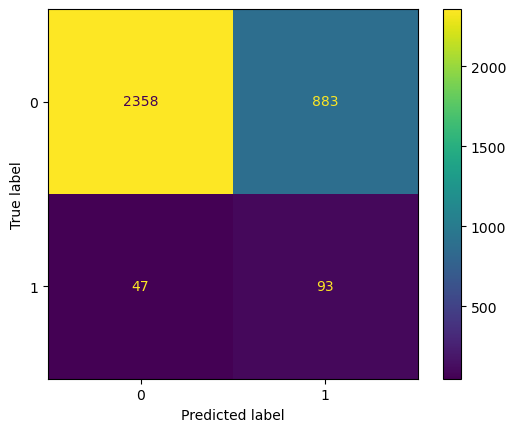

In [139]:
eval(param_model(n_estimators = 80, 
                 max_depth = 37, 
                 max_features = 3,
                 min_impurity_decrease = 1e-10,
                 max_samples=0.98))

### class weight

In [ ]:
y_train.value_counts()

In [ ]:
test_params(n_estimators = 40, max_depth = 30, bootstrap=False)

              precision    recall  f1-score   support

           0       0.98      0.73      0.84      3241
           1       0.09      0.64      0.16       140

    accuracy                           0.73      3381
   macro avg       0.54      0.68      0.50      3381
weighted avg       0.94      0.73      0.81      3381



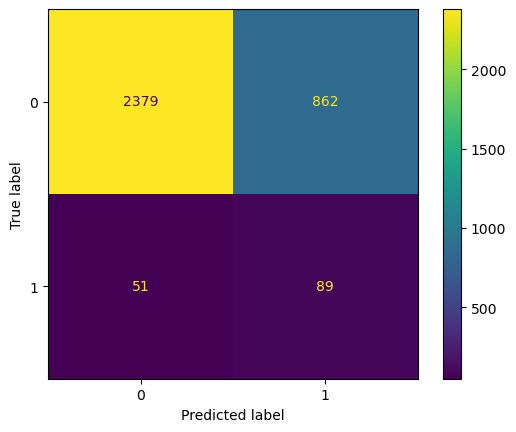

In [149]:
eval(param_model(n_estimators = 80, 
                 max_depth = 37, 
                 max_features = 3,
                 min_impurity_decrease = 1e-10,
                 class_weight={'0': 1, '1': 2})) #give higher weightage to the underrepresented class 1.0

In [150]:
updated_rf = RandomForestClassifier(n_estimators = 80, 
                 max_depth = 37, 
                 max_features = 3,
                 min_impurity_decrease = 1e-10,
                 bootstrap=False, 
                 class_weight='balanced').fit(X_train, y_train)

## Check Feature importance

In [152]:
# Feature Importance
importance_df = pd.DataFrame({ 
    'feature': X.columns, 
    'importance': updated_rf.feature_importances_
}).sort_values('importance', ascending=True)
importance_df.head(10)

,feature,importance
37,sumins_inv,0.000092
12,flg_has_life_claim,0.000166
9,flg_is_revised_term,0.000347
54,f_ever_bought_inv,0.000372
46,n_months_since_lapse_ltc,0.000408
56,n_months_last_bought,0.000496
33,ape_inv,0.000532
15,flg_with_preauthorisation,0.000661
16,flg_is_returned_mail,0.000767
41,prempaid_inv,0.000860


In [155]:
importance_df.head(10)['feature'].tolist()

['sumins_inv',
 'flg_has_life_claim',
 'flg_is_revised_term',
 'f_ever_bought_inv',
 'n_months_since_lapse_ltc',
 'n_months_last_bought',
 'ape_inv',
 'flg_with_preauthorisation',
 'flg_is_returned_mail',
 'prempaid_inv']

In [158]:
X = X.drop(columns=importance_df.head(10)['feature'].tolist())

In [159]:
X_train = X_train.drop(columns=importance_df.head(10)['feature'].tolist())
X_val = X_val.drop(columns=importance_df.head(10)['feature'].tolist())

In [160]:
updated_rf2 = RandomForestClassifier(n_estimators = 80, 
                 max_depth = 37, 
                 max_features = 3,
                 min_impurity_decrease = 1e-10,
                 bootstrap=False, 
                 class_weight='balanced').fit(X_train, y_train)

              precision    recall  f1-score   support

           0       0.98      0.72      0.83      3241
           1       0.09      0.67      0.16       140

    accuracy                           0.72      3381
   macro avg       0.54      0.70      0.50      3381
weighted avg       0.94      0.72      0.80      3381



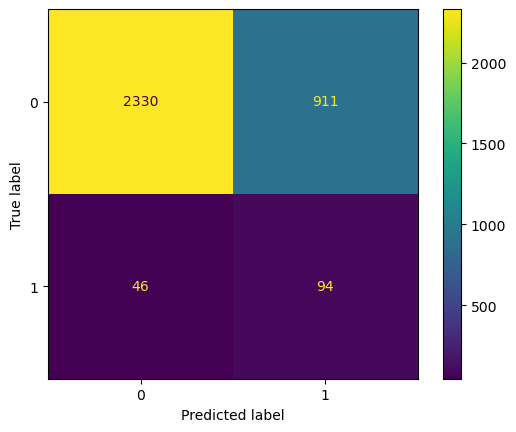

In [161]:
eval(updated_rf2)

# Decision Tree

In [10]:
from sklearn.tree import DecisionTreeClassifier

In [11]:
dt_clf = DecisionTreeClassifier()
dt_clf.fit(X_train, y_train)
print("train accuracy: ", dt_clf.score(X_train, y_train))
print("val accuracy: ", dt_clf.score(X_val, y_val))

train accuracy:  1.0
val accuracy:  0.6577935522034901


              precision    recall  f1-score   support

           0       0.97      0.66      0.79      3241
           1       0.07      0.60      0.13       140

    accuracy                           0.66      3381
   macro avg       0.52      0.63      0.46      3381
weighted avg       0.94      0.66      0.76      3381



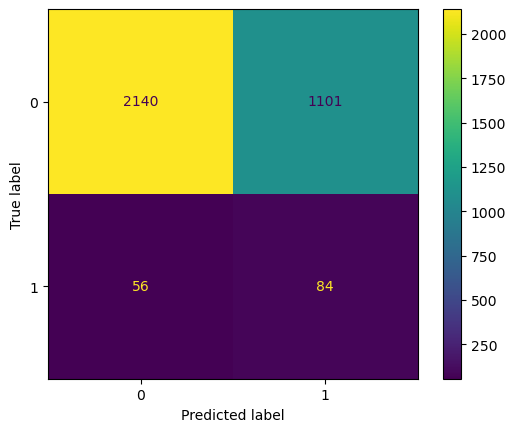

In [16]:
eval(dt_clf)

# KNN (skip)

In [35]:
from sklearn.neighbors import KNeighborsClassifier

In [38]:
# assume X_train, y_train are df/numpy objects
knn_clf = KNeighborsClassifier(n_neighbors=2)
knn_clf.fit(X_train, y_train)
knn_clf.predict(X_val)

AttributeError: 'Flags' object has no attribute 'c_contiguous'

# Evaluate

### Confusion Matrix

In [15]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# Evaluate on validation set
def eval(model):
    y_val_pred = model.predict(X_val)
    print(classification_report(y_val, y_val_pred))

    # Code to generate visualisation of matrix
    cm = confusion_matrix(y_val, y_val_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,) # set display_label according to dataset
    disp.plot()


In [ ]:
cm

### ROC

In [ ]:
y_val

In [ ]:
len(y_val_pred)

In [ ]:
# ROC curve
from sklearn.metrics import roc_curve, auc
train_pred = [int(i) for i in y_val_pred]
y_val1 = [int(i) for i in y_val]
fpr, tpr, thresholds = roc_curve(y_val1, train_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Visualize Tree

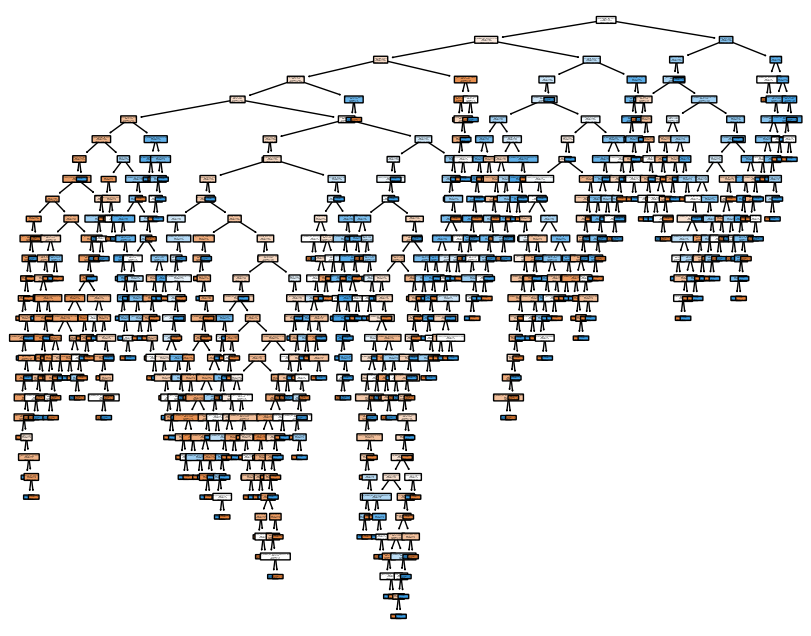

In [162]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plot_tree(updated_rf2.estimators_[0], feature_names=X_train.columns.tolist(), filled=True, rounded=True)
plt.show()

## The cell below is **NOT** to be removed
##### The function is to be amended so that it accepts the given input (dataframe) and returns the required output (list). 
##### It is recommended to test the function out prior to submission
-------------------------------------------------------------------------------------------------------------------------------
##### The hidden_data parsed into the function below will have the same layout columns wise as the dataset *SENT* to you
##### Thus, ensure that steps taken to modify the initial dataset to fit into the model are also carried out in the function below

In [ ]:
def testing_hidden_data(hidden_data: pd.DataFrame) -> list:
    '''DO NOT REMOVE THIS FUNCTION.

The function accepts a dataframe as input and return an iterable (list)
of binary classes as output.

The function should be coded to test on hidden data
and should include any preprocessing functions needed for your model to perform. 
    
All relevant code MUST be included in this function.'''
    result = [] 
    return result

##### Cell to check testing_hidden_data function

In [ ]:
# This cell should output a list of predictions.
test_df = pd.read_parquet(filepath)
test_df = test_df.drop(columns=["f_purchase_lh"])
print(testing_hidden_data(test_df))

### Please have the filename renamed and ensure that it can be run with the requirements above being met. All the best!